## Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Extended Model

This notebook is for improvements to the logistic regression model in the 'Baseline Model' notebook. We will extend by trying a Random Forest Classfier and a multilayer Neural Net. To develop improved results, we will examine two strategies for dealing with the imbalance in the data (noted in the 'Data Exploration' notebook).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

In [2]:
Xy_crop_df=pd.read_csv('Xy_crop_df.csv',index_col=0)

The classifiers we are trying here are known to work better with scaled data, so we will fit a standard scaler at this point. Since we will also do image augmentation later on, which needs pre-scaled data, we'll fit now and transform the train sets later.

In [3]:
scaler = StandardScaler()
scaler.fit(Xy_crop_df.iloc[:,:3072].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Xy_crop_df.iloc[:,:3072].values,
                                                Xy_crop_df.label.values,
                                                stratify=Xy_crop_df.label.values,
                                                random_state=42)

In [5]:
X_train_scaled = scaler.transform(X_train) #scale train set and save as new
X_test = scaler.transform(X_test) #scale test set


Now that we are ready, we will use a Random Forest classifier as a baseline since it showed some improvement over the the Logistic Regression in a previous notebook.

In [6]:
model = RandomForestClassifier(n_jobs=-1)
# Fit on training data
model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     32727
           1       0.77      0.59      0.67     22280

    accuracy                           0.76     55007
   macro avg       0.77      0.74      0.74     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:
[[28783  3944]
 [ 9058 13222]]


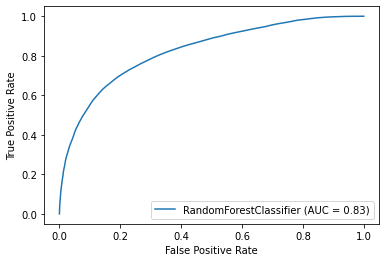

In [7]:
print('Classification Report (test):')
print(classification_report(y_test,model.predict(X_test)))
print('Confusion Matrix:')
print(confusion_matrix(y_test,model.predict(X_test)))
plot_roc_curve(model,X_test,y_test)
plt.show()

We are aiming for much mbetter results than this. One of the easiest issues to see is the imbalance in the data. There are 40.5% positive and 59.5% negative samples. Let's examine how we can address this issue.


In [8]:
pos=len(y_train[y_train==1])
neg=len(y_train[y_train==0])
print('n Positive: ',pos)
print('n Negative: ',neg)
print('difference: ',neg-pos)
print('total: ',pos+neg)

n Positive:  66837
n Negative:  98181
difference:  31344
total:  165018


There are $$\binom{31344}{154018}$$ (way too many) different ways to randomly undersample the majority class so that it matches the number of the minority class here, so we have to choose a subset. 

We will take a few subsets, and put them in a pipeline using the same random forest classifier as before. Then we'll roll them all into an ensemble classifier that uses majority vote to determine the classification of each sample.

In [9]:
n_iter=6 #number of iteriations

rus=RandomUnderSampler()
rfc=RandomForestClassifier(n_jobs=-1)
pipes=[]
samplers=[]
pipe_names=[]

In [10]:
for seed in range(n_iter):
    pipe_names.append('pipe_'+str(seed))
    samplers.append(RandomUnderSampler(random_state=seed))    
    pipes.append((pipe_names[seed],make_pipeline(samplers[seed],rfc)))

In [11]:
from sklearn.ensemble import VotingClassifier

clf=VotingClassifier(estimators=pipes,n_jobs=-1)

In [12]:
clf.fit(X_train_scaled,y_train)

VotingClassifier(estimators=[('pipe_0',
                              Pipeline(memory=None,
                                       steps=[('randomundersampler',
                                               RandomUnderSampler(random_state=0,
                                                                  replacement=False,
                                                                  sampling_strategy='auto')),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      class_weight=None,
                                                                      criterion='gini',
                                                                      max_depth=None,
                                                                      m

In [13]:
pred=clf.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     32727
           1       0.72      0.71      0.71     22280

    accuracy                           0.77     55007
   macro avg       0.76      0.76      0.76     55007
weighted avg       0.77      0.77      0.77     55007

Confusion Matrix:
[[26539  6188]
 [ 6541 15739]]


As predicted, a random undersampling gave us an improvement in recall for the minority (positive) set. 
  
The other way we can handle the imbalance is by oversampling the minority set rather than undersampling the majority set. 
  
A common way to do this with data like this is image augemntation. We will perturb some images in the minority set to create new ones.

### image augmentation with imgaug


In [14]:
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import imgaug as ia


The image transformations we will be using expect to see images in the typical shape (3-d arrays of int values 0-255), so we need to start from the loaded data and reshape the it before scaling.

Many transformations assume the images are in the normal shape (3-d array) so we're going to reshape the images back to that shape first

In [15]:
#reshape the images and recast as uint8
X_train=X_train.reshape((X_train.shape[0],32,32,3)).astype(np.uint8)

In [16]:
#pull out the positive images.
#Recall from earlier this is the minority class we need to augment
Xy_z=zip(X_train,y_train)

X_p=[]
for X,y in Xy_z:
    if y==1:
        X_p.append(X)
       

We need to be somewhat careful shoosing which transformations to apply to the images. We know that the a positive slide is defined as having 1 pixel of cancer cell in it. But without specific domain knowledge about exactly how to identify those cells we need to be careful that any transformations don't degrade that information, either by changing pixel values too much or by removing important pixels.

Given that, we will apply transformations that shift pixel location but not pixel values. Some examples of these are:
* Flipping
* Rotation
* Skew

In [17]:
# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
       
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Flipud(1.0), # vertically flip
        iaa.Rot90(1,3),  # rotate 90, 180, or 270 degrees        
    ])    
],
random_order=True 
)

In [18]:
#make a random selection of positive samples
n_aug=len(X_train)-2*len(X_p) #number of samples to augment the class by

X_p=shuffle(X_p)


In [19]:
# Apply augmentation pipeline
X_aug = np.array([aug_pipeline.augment_image(each) for each in X_p[:n_aug]])

In [20]:
X_augl = list(X_aug[:4])

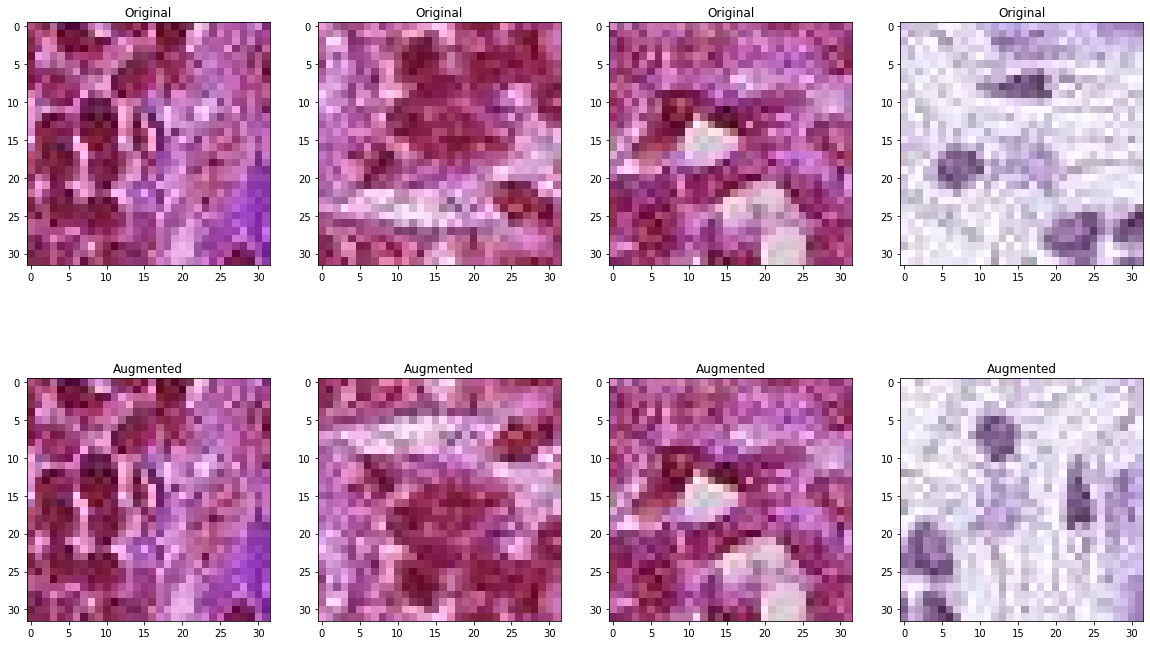

In [21]:
fig,ax = plt.subplots(2,4, figsize=(20,12))
#4 original
for i in range(4):
    ax[0,i].imshow(X_p[i])
    ax[0,i].set_title('Original')

#4 augmented
for i in range(4):
    ax[1,i].imshow(X_aug[i])
    ax[1,i].set_title('Augmented')
plt.show()

In [22]:
#flatten the images
X_train=np.array([each.flatten() for each in X_train])
X_aug=np.array([each.flatten() for each in X_aug])

In [23]:
#add augmented images to the training set
X_train=np.concatenate((X_train,X_aug))

In [24]:
#add labels to y_test
y_aug=np.full((len(X_aug),),1)

y_train=np.concatenate((y_train,y_aug))

In [25]:
#scale the training set
X_train = scaler.transform(X_train) 

In [26]:
mod_aug = RandomForestClassifier(n_jobs=-1)
mod_aug.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     32727
           1       0.71      0.70      0.71     22280

    accuracy                           0.76     55007
   macro avg       0.76      0.76      0.76     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:
[[26360  6367]
 [ 6574 15706]]


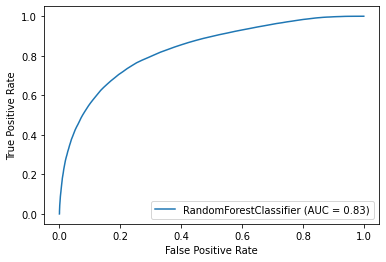

In [27]:
pred=mod_aug.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mod_aug,X_test,y_test)
plt.show()

### Hyperparameter Tuning

We can also look for improvement by tuning the hyperparameters of the classifier used. In this case there are several relevant hyperparameters that may impact performance, so we will use a Randomized Search cross Vallidation to choose 30 different combinations to try, then implement the best one found.

In [28]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

#parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 4)]
max_features = [None,'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
        }

In [ ]:
rfc=RandomForestClassifier(n_jobs=-1)

rf_rand=RandomizedSearchCV(estimator=rfc, 
                           param_distributions=params, 
                           n_iter=25,
                           cv=3, 
                           n_jobs=-1,
                           return_train_score=True)

rf_rand.fit(X_test,y_test).best_params_

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
mod_t = RandomForestClassifier(n_estimators=2066,                               
                               min_samples_split=2,
                               min_samples_leaf=4,
                               n_jobs=-1)
mod_t.fit(X_train, y_train)

In [ ]:
pred=mod_t.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mod_t,X_test,y_test)
plt.show()

In [ ]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

#parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 4)]
max_features = [None,'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params={'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
        }

In [ ]:
rfc=RandomForestClassifier(n_jobs=-1)

rf_rand=RandomizedSearchCV(estimator=rfc, 
                           param_distributions=params, 
                           n_iter=25,
                           cv=3, 
                           n_jobs=-1,
                           return_train_score=True)

rf_rand.fit(X_test,y_test).best_params_

In [ ]:
mod_t = RandomForestClassifier(n_estimators=2066,                               
                               min_samples_split=2,
                               min_samples_leaf=4,
                               n_jobs=-1)
mod_t.fit(X_train, y_train)

In [ ]:
pred=mod_t.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mod_t,X_test,y_test)
plt.show()

### Summary

By undersampling, we were able to improve performance of the classifiers somewhat, and by oversampling with image augmentation we were able to achieve slightly better imporvements as you see in the table below:


| Model | Class | Precision | Recall | AUC | 
| --- | --- | --- | --- | --- |
| Baseline Logistic Regression | 0 | 0.72 | 0.83 | 0.83 |
| | 1 | 0.67 | 0.52 | |
| Baseline Random Forest | 0 | 0.76 | 0.88 | 0.83 |
|  | 1 | 0.77 | 0.59 | |
| Undersampling Ensemble | 0 | 0.80 | 0.81 | |
| | 1 | 0.72 | 0.71 | |
| Image Augmentation | 0 | 0.80 | 0.81 | 0.83 |
| | 1 | 0.72 | 0.70 | |
| Image Augmentation with | 0 | 0.81 | 0.80 | 0.84 |
| Hyperparameter Tuning | 1 | 0.71 | 0.73 | |

We can see from this table that both of the tested methods of balancing the dataset -- random undersampling and random image augmentation -- yield similar improvement.  

It should be possible to get a little more performance with hyperparameter tuning. We could use a randomized search cross-validation to find better parameters for the random forest, but with this size of dataset it is rather too resource intensive for this notebook. Also note that in earlier testing on a smaller set, hyperparameter tuning yielded only a small improvement to performance metrics. 

### Conclusions

We had some small success using a random forest classifier coupled with dataset balancing techniques of random undersampling and image augemntation to gain small improvements to the classifier's performance metrics. These results still fall short of our goal.  
The goal was to develop a classifier that may be useful for helping a clinician identify lymph note slides containing cancer. 0.70 to 0.72 precision and recall are not enough to be very useeful.  
  
So how do we improve this? one of the challenges experienced here may point the way. We attempted to try a neural net (Scikit-Leaern's multi-level perceptron classifier), but on this size of dataset, and with the algorithm not lending itself at all to parallelization, the time it took to get any results makes the problem essentially intractable within this notebook.  
  
Further work to improve results should be a modeling strategy that is known to work well for this class of problem, (e.g. a convolute neural net), using a software package that can more effectively exploit CPU and GPU power than Scikit-Learn's nerual nets do.
 
